# Getting the sensitivity of the PWFS system for spatial frequencies


The objective is to compare the sensitivity of unmodulated, modulated and 2 flavors of "Time-Resolved" modulated TRWFSs. More specifically, we are using the sensitivity to spatial frequencies.

We start by initializing the system with OOPAO

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

In [4]:

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import TR_Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_CMOS_PWFS_aug2022_3 import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()
param["nModes"] = 60
param['modulation'] = 3
# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


wfs = TR_Pyramid(nSubap=param['nSubaperture'], \
                 telescope=tel, \
                 modulation=param['modulation'], \
                 lightRatio=param['lightThreshold'], \
                 n_pix_separation=4,
                 calibModulation=param['calibrationModulation'], \
                 psfCentering=param['psfCentering'], \
                 n_pix_edge=2,
                 extraModulationFactor=param['extraModulationFactor'], \
                 postProcessing=param['postProcessing'],
                 nTheta_user_defined = param['nTheta_user_defined'])


bases, cycles_in_pupil = generateFourierBasesWithAngle(bases=param["nModes"], resolution=120, angle=np.pi/4, maxCycles=12)

# Change the first base to be flat (cycle=0)
bases[0,:,:] = tel.pupil
cycles_in_pupil[0] = 0

# Set the RMS of all bases to 1
for b in range(bases.shape[0]):
    bases[b,tel.pupil==0] = 0
    piston = np.mean(bases[b, tel.pupil])
    bases[b,:,:] -= tel.pupil*piston
    rms_calc = np.sqrt(np.mean(np.square(bases[b, tel.pupil])))
    bases[b, :,:] /= tel.pupil*rms_calc
    bases[b,tel.pupil==0] = 0

# Set the RMS of each base to 1 Rad
bases = bases * (ngs.wavelength / (2*np.pi))


bases_2D = bases
bases = bases.reshape(param["nModes"], 120**2)
# mode to command matrix to project on DM
test = np.linalg.pinv(np.squeeze(dm.modes))
M2C_cycles = test@bases.T


Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             24               [m]        
    Resolution           120             [pixels]     
    Pixel Size           0.2               [m]        
     Surface            452.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      11304            [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 Source Wavelength Zenith  Azimuth   Altitude Magnitude    Flux   
           [m]    [arcsec]  [deg]      [m]              [phot/m2/s]
-------------------------------------------------------------------
  NGS    7.9e-07     0        0        inf       1.0    29208950

/tmp/ipykernel_17249/206731152.py:84: RuntimeWarning: invalid value encountered in divide
  bases[b, :,:] /= tel.pupil*rms_calc


# Getting the OPD of the first 20 modes

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


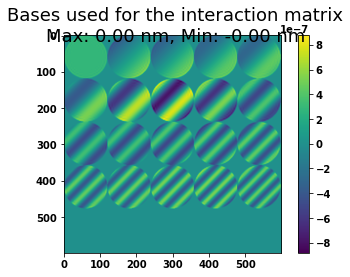

In [5]:
dm.coefs = M2C_cycles[:, 0:20]
tel * dm * wfs
displayMap(tel.OPD)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


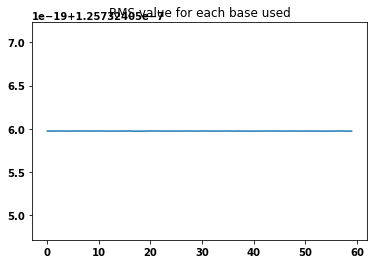

In [6]:
bases_rms = np.zeros(bases_2D.shape[0])
for b in range(bases_2D.shape[0]):
    bases_rms[b] = np.sqrt(np.mean(np.square(bases_2D[b, tel.pupil])))

plt.figure()
plt.plot(bases_rms)
plt.title("RMS value for each base used")
plt.show()


# Getting the reference image to see if all 4 quadrants are equal

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


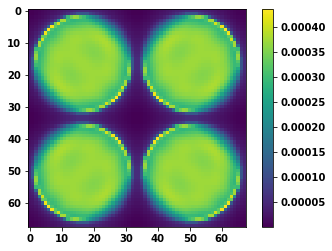

In [7]:
dm.coefs = 0
wfs.modulation = param["modulation"]
tel * dm * wfs
im = plt.imshow(wfs.referenceSignal_2D)
im1_cbar = plt.colorbar(im)

# Calculating the weights of each frame along the modulation for the spatial "fourier" modes

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 0, 'Mode number')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

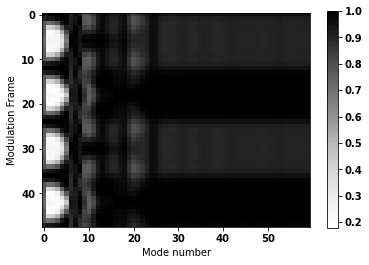

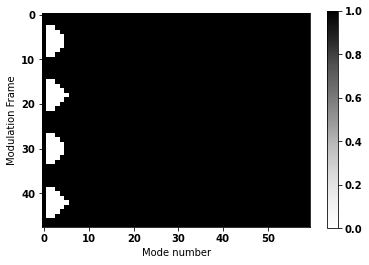

In [8]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = param["nModes"]
stroke = 1 # Stroke 1 rad?

i_cube = np.zeros((wfs.nTheta, np.sum(wfs.validSignal), nModes))
# ngs.nPhoton = 10000000000
wfs.modulation = param['modulation']
dm.coefs = 0
ngs* tel * dm * wfs
ref_cube = wfs.cam.cube[:, wfs.validSignal]

# bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)
for i in range(nModes):
    dm.coefs = M2C_cycles[:, i] * stroke
    tel * dm * wfs
    push = wfs.cam.cube[:, wfs.validSignal]
    push_signal = push/np.sum(push) - \
                      ref_cube/np.sum(ref_cube)

    dm.coefs = -M2C_cycles[:, i] * stroke
    tel * dm * wfs
    pull = wfs.cam.cube[:, wfs.validSignal]
    pull_signal = pull/np.sum(pull) - \
                      ref_cube/np.sum(ref_cube)

    i_cube[:,:,i] = (0.5 * (push_signal - pull_signal) / stroke)

plt.figure()

weighting_cube = np.zeros((wfs.nTheta, nModes))
for i in range(nModes):
    avg_val = np.mean(i_cube[:, :, i])
    #weighting_cube[:,i] = (np.std(i_cube[:, :, i], axis=1))
    weighting_cube[:,i] = (np.sqrt(np.mean((i_cube[:, :, i]-avg_val)**2, axis=1)))
    #weighting_cube[:,i] = weighting_cube[:,i] - np.min(weighting_cube[:,i])
    weighting_cube[:,i] = weighting_cube[:,i]  / np.max(np.abs(weighting_cube[:,i]))

plt.figure()
im = plt.imshow(weighting_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("Mode number")
plt.figure()
binary_weight_cube = np.copy(weighting_cube)
threshold = 0.5
binary_weight_cube[weighting_cube < threshold] = 0
binary_weight_cube[weighting_cube >= threshold] = 1

# framesRemPerFace = [11, 11, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5,
#                                       3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
# binary_weight_cube = np.ones((wfs.nTheta, nModes))
# for f in range(len(framesRemPerFace)):
#     idx = calcEquidistantFrameIndices(framesRemPerFace[f], wfs.nTheta)
#     binary_weight_cube[idx, f] = 0


im = plt.imshow(binary_weight_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("Mode number")

# Now we calculate the interaction matrix for 4 flavors: unmodulated, modulated, modulated with weights and modulated with binary weights (0 or 1).

Formulas used:

$$ \Delta I(\phi) = \frac{I(\phi)}{N} - \frac{I_0}{N_0}  $$ (eq. 2.11)

$$ \delta I (\phi_i) = \frac{\Delta I(\epsilon \phi_i) - \Delta I(-\epsilon \phi_i)}{2\epsilon} $$ (eq. 2.12)

$$ \mathcal{D} = ( \delta I(\phi_1), \delta I(\phi_2), ...,\delta I(\phi_{N_{modes}})  )$$ (eq. 2.13)

In [9]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = param["nModes"]
stroke = 1 # Stroke 1 rad?


def getInterationMatrixModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = wfs.cam.cube[:, wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_cycles[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.cube[:, wfs.validSignal]
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_cycles[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.cube[:, wfs.validSignal]
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )
    return imat

def getInterationMatrixUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = wfs.cam.frame[wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_cycles[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.frame[wfs.validSignal]
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)


        dm.coefs = -M2C_cycles[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.frame[wfs.validSignal]
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )

    return imat

I_mat_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
I_mat_unmodulated = getInterationMatrixUnmodulated()
I_mat_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
I_mat_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])


I_mat_modulated_inv = inv(I_mat_modulated.T @ I_mat_modulated) @ I_mat_modulated.T
I_mat_unmodulated_inv = inv(I_mat_unmodulated.T @ I_mat_unmodulated) @ I_mat_unmodulated.T
I_mat_weighted_inv = inv(I_mat_weighted.T @ I_mat_weighted) @ I_mat_weighted.T
I_mat_binary_inv = inv(I_mat_binary.T @ I_mat_binary) @ I_mat_binary.T


Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 1.0, 'Identity of TR reconstructor. RMS err = 2.5358479417258743e-09')

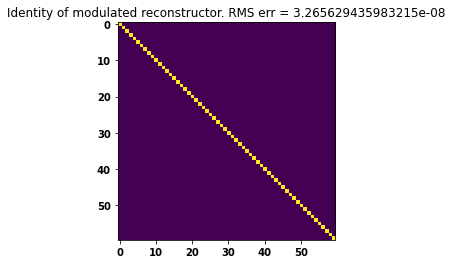

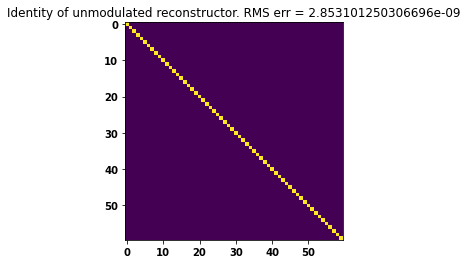

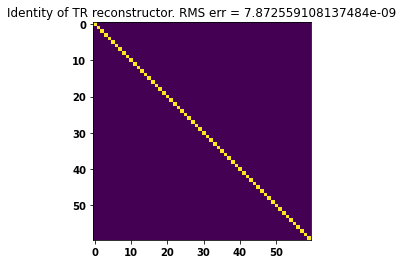

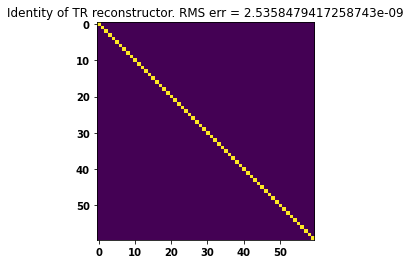

In [10]:
plt.figure()
plt.imshow(I_mat_modulated_inv@I_mat_modulated)
diag_modulated_err_rms = np.sqrt(np.mean((I_mat_modulated_inv@I_mat_modulated - np.identity(nModes))**2))
plt.title(f"Identity of modulated reconstructor. RMS err = {diag_modulated_err_rms}")
plt.figure()
plt.imshow(I_mat_unmodulated_inv@I_mat_unmodulated)
diag_unmodulated_err_rms = np.sqrt(np.mean((I_mat_unmodulated_inv@I_mat_unmodulated - np.identity(nModes))**2))
plt.title(f"Identity of unmodulated reconstructor. RMS err = {diag_unmodulated_err_rms}")
plt.figure()
plt.imshow(I_mat_weighted_inv@I_mat_weighted)
diag_weighted_err_rms = np.sqrt(np.mean((I_mat_weighted_inv@I_mat_weighted - np.identity(nModes))**2))
plt.title(f"Identity of TR reconstructor. RMS err = {diag_weighted_err_rms}")
plt.figure()
plt.imshow(I_mat_binary_inv@I_mat_binary)
diag_binary_err_rms = np.sqrt(np.mean((I_mat_binary_inv@I_mat_binary - np.identity(nModes))**2))
plt.title(f"Identity of TR reconstructor. RMS err = {diag_binary_err_rms}")

# Finally, with the interaction matrix, we should be able the calculate the sensitivity of the system.
This is the part I struggle with, I am usure why I don't get values between 0 and 2 like in the litterature. Here I'm following formula 3.11 from Chambouleyron's thesis.

$$ s_b (\phi_i) = \| \delta I(\phi_i) \|_2   $$

Changed to

$$ s_b (\phi_i) = \sqrt{N_{SubAp}} \| \delta I(\phi_i) \|_2   $$

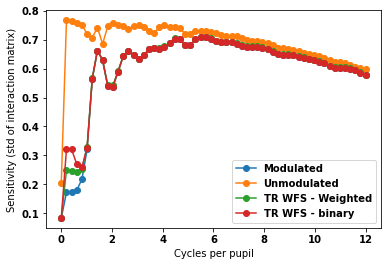

In [11]:
plt.figure()
radian_in_1m = 1 #(2*np.pi)/ ngs.wavelength
plt.plot(cycles_in_pupil, np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_modulated)**2, axis=0)) / radian_in_1m, marker="o",label="Modulated")
plt.plot(cycles_in_pupil, np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_unmodulated )**2, axis=0)) / radian_in_1m, marker="o",label="Unmodulated")
plt.plot(cycles_in_pupil, np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_weighted )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Weighted")
plt.plot(cycles_in_pupil, np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_binary )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - binary")
plt.xlabel("Cycles per pupil")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.legend()

## Trying to reproduce the formula 3.20 from Chambouleron's thesis.

$$ s_\gamma (\phi_i) = \| \frac{\delta I(\phi_i)}{\sqrt{I_0}} \|_2 $$

In [12]:
tel - atm
wfs.cam.photonNoise = False
nModes = param["nModes"]
stroke = 1 # stroke 1 rad?


def getSensitivityModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = int(wfs.cam.cube[:, wfs.validSignal])

    for m in range(nModes):
        dm.coefs = M2C_cycles[:, m] * stroke
        tel * dm * wfs

        push = int(wfs.cam.cube[:, wfs.validSignal])
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_cycles[:, m] * stroke
        tel * dm * wfs

        pull = int(wfs.cam.cube[:, wfs.validSignal])
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        imat[:,m] = imat[:,m] / np.sqrt(np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m]))
        #imat[:,m] /= np.max(imat[:,m] )
    return imat

def getSensitivityUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = int(wfs.cam.frame[wfs.validSignal])

    for m in range(nModes):
        dm.coefs = M2C_cycles[:, m] * stroke
        tel * dm * wfs

        push = int(wfs.cam.frame[wfs.validSignal])
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)



        dm.coefs = -M2C_cycles[:, m] * stroke
        tel * dm * wfs

        pull = int(wfs.cam.frame[wfs.validSignal])
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)



        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)

        # Divide by the square root of the normalized reference image
        imat[:,m] = imat[:,m] / np.sqrt(ref_frame/np.sum(ref_frame))

    return imat

s_y_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
s_y_unmodulated = getInterationMatrixUnmodulated()
s_y_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
s_y_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


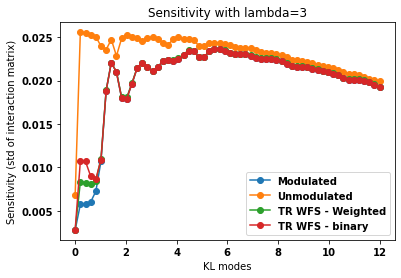

In [13]:
radian_in_1m = 1
plt.figure()
plt.plot(cycles_in_pupil, np.sqrt(np.sum(np.square(s_y_modulated), axis=0))/ radian_in_1m, marker="o", label="Modulated")
plt.plot(cycles_in_pupil, np.sqrt(np.sum(np.square(s_y_unmodulated), axis=0))/ radian_in_1m, marker="o", label="Unmodulated")
plt.plot(cycles_in_pupil, np.sqrt(np.sum(np.square(s_y_weighted), axis=0))/ radian_in_1m, marker="o", label="TR WFS - Weighted")
plt.plot(cycles_in_pupil, np.sqrt(np.sum(np.square(s_y_binary), axis=0))/ radian_in_1m, marker="o", label="TR WFS - binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.title(f"Sensitivity with lambda={param['modulation']}")
plt.legend()